# Seversteel. Binary segmentation task with pytorch lightning

## 1. Generating sample and defects visualisation

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict

In [36]:
train_df = pd.read_csv("train.csv")
train_path = "train_images"
train_df.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


In training dataframe we have separate entries for each defect on the image, so we need to merge rows with same image

In [37]:
len(train_df["ImageId"].to_list()), len(os.listdir("train_images"))

(7095, 12568)

In [38]:
new_df = train_df.copy()
rows_with_same_image = defaultdict(list)
dict_of_classes = defaultdict(list)
rows_to_drop = []
for row in range(len(train_df)):
    img_name = train_df.iloc[row, 0]
    label = train_df.iloc[row, 1]
    if img_name in rows_with_same_image.keys():
#         print(row)
        oldrow = rows_with_same_image[img_name][0]
        new_df.iloc[oldrow, 1] = str(new_df.iloc[oldrow, 1])+ " " +str(label)
        new_df.iloc[oldrow, 2] = new_df.iloc[oldrow, 2] + " " + new_df.iloc[row, 2]
#         print(new_df.iloc[oldrow, 1])
        rows_to_drop.append(row)
    dict_of_classes[label].append(img_name)
    rows_with_same_image[img_name].append(row)
    
new_df = new_df.drop(rows_to_drop)
new_df["IsDefect"] = 1
new_df = new_df.reset_index(drop=True)
new_df.head(10)


,ImageId,ClassId,EncodedPixels,IsDefect
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1
5,0025bde0c.jpg,3 4,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,1
6,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...,1
7,002fc4e19.jpg,1 2,146021 3 146275 10 146529 40 146783 46 147038 ...,1
8,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...,1
9,0046839bd.jpg,3,152926 1 153180 4 153434 6 153689 8 153943 11 ...,1


In [39]:
import random
for i in range(1,5):
    random.Random(42).shuffle(dict_of_classes[i])

set_of_classes = set(new_df["ClassId"].copy().to_list())
set_of_classes

{1, '1 2', '1 2 3', '1 3', 2, '2 3', '2 4', 3, '3 4', 4}

Set of classes that each image can belong to

In [43]:
label_dict = defaultdict(list)
number_dict = defaultdict(list)
for image in os.listdir("train_images"):
    if image in train_df["ImageId"].to_list():
        label_dict[1].append(image)
    else:
        label_dict[0].append(image)
no_defect_images = label_dict[0]
defect_images = label_dict[1]
print("Number of images with no defects: ", len(no_defect_images), "\nNumber of images with defects: ", len(defect_images))

Number of images with no defects:  5902 
Number of images with defects:  6666


In [45]:
df_nodefect = pd.DataFrame(columns=['ImageId', 'ClassId', 'EncodedPixels', 'IsDefect'])
df_nodefect['ImageId'] = no_defect_images
df_nodefect['IsDefect'] = 0
df_nodefect['ClassId'] = 0

sample_nodefect = df_nodefect.sample(frac = 1, random_state = 42)[:500].copy()

full data stack, 12568 entries

In [49]:
full_df = pd.concat([new_df, df_nodefect])
full_df

,ImageId,ClassId,EncodedPixels,IsDefect
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,1
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,1
...,...,...,...,...
5897,13baad39e.jpg,0,NaN,0
5898,ba1d5f5b5.jpg,0,NaN,0
5899,d52f44bd0.jpg,0,NaN,0
5900,2858af68b.jpg,0,NaN,0


In [50]:
sample_df = sample_nodefect.copy()

sample_images = []
other_images = []
clssnames={i: [] for i in range(1,5)}
for key in range(1,5):
    for el in set_of_classes:
        if str(key) in str(el):
            clssnames[key].append(el)
    
for clss in range(1,5):
    clss_df = new_df[ (new_df["ClassId"].isin(clssnames[clss])) & (~new_df["ImageId"].isin(sample_images)) ].sample(frac = 1, random_state = 42)
    sample_clss_df = clss_df[:125].copy()    
    sample_df = pd.concat([sample_df, sample_clss_df])  
    sample_images.extend(sample_clss_df["ImageId"].to_list())
    
    
sample_df = sample_df.sample(frac = 1, random_state = 42).reset_index(drop=True)

In [51]:
sample_df[sample_df.duplicated()]

,ImageId,ClassId,EncodedPixels,IsDefect


## Balanced sample of 1000 images, where 500 images don't have defects and at least 125 images of each defect class are included (cause one image can contain more than one defect)

In [53]:
sample_df

,ImageId,ClassId,EncodedPixels,IsDefect
0,837645cf1.jpg,1,320225 32 320418 95 320611 158 320804 221 3210...,1
1,22a825813.jpg,2,117735 13 117967 37 118199 60 118431 84 118663...,1
2,a44dd8116.jpg,2,382469 19 382724 45 382980 55 383235 66 383315...,1
3,8b9c035ec.jpg,2,183521 32 183713 96 183905 160 184097 2240 186...,1
4,8b9050902.jpg,0,NaN,0
...,...,...,...,...
995,4bd3d3a2a.jpg,0,NaN,0
996,8a58a494a.jpg,0,NaN,0
997,708c66026.jpg,3,256001 128 256259 254 256515 254 256771 254 25...,1
998,6724b9623.jpg,0,NaN,0


In [54]:
other_df = pd.concat([full_df, sample_df]).drop_duplicates(keep=False).sample(frac = 1, random_state = 42).reset_index(drop=True)

In [55]:
other_df

,ImageId,ClassId,EncodedPixels,IsDefect
0,8976f1c8b.jpg,0,NaN,0
1,9ad20b22f.jpg,0,NaN,0
2,c2afd0495.jpg,3,295022 17 295238 57 295480 71 295734 72 295988...,1
3,cf7dbc448.jpg,3,59905 32 60161 96 60417 160 60673 224 60929 65...,1
4,e75d92916.jpg,0,NaN,0
...,...,...,...,...
11563,87b82c9cb.jpg,0,NaN,0
11564,d66e4eb3f.jpg,3,65 7 309 19 559 25 815 25 1071 25 1327 25 1583...,1
11565,de85c63cb.jpg,3 4,250185 7 250431 19 250677 31 250922 45 251168 ...,1
11566,23e4a530a.jpg,2,382726 26 382981 77 383237 127 383492 178 3837...,1


In [56]:
# sample_df.to_csv("balanced_4class_sample.csv", index=False)
# other_df.to_csv("other_4class.csv", index=False)

## So balanced sample of 1000 images and dataframe with other images for test were generated
### Visualisation of defect on image is below.

In [71]:
def make_show_mask(row, df):
    
    img_name = df.iloc[row, 0]
    path = train_path+"/"+img_name
#     rows_with_this_image = rows_with_same_image[img_name]
#     encoded_pixels = []
#     for elraw in rows_with_this_image:
#         encoded_pixels+=train_df.iloc[elraw, 2].split(" ")
    
    mask = np.zeros((256, 1600), dtype=np.uint8)
    encoded_pixels=df.iloc[row, 2]
    if encoded_pixels is not np.nan:
        encoded_pixels = encoded_pixels.split(" ")
    
        positions = map(int, encoded_pixels[0::2])
        length = map(int, encoded_pixels[1::2])

        
        mask_label = np.zeros(1600*256, dtype=np.uint8)
        for po, le in zip(positions, length):
            mask_label[po-1:po+le-1] = 1
        mask[:, :] = mask_label.reshape(256, 1600, order='F')
    
    img = cv2.imread(path)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    contours, _ = cv2.findContours(mask[:, :], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(0, len(contours)):
        cv2.polylines(img, contours[i], True, (255, 0, 255), 2)
    ax.set_title(img_name)
    ax.imshow(img) #, cmap='gray', vmin=0, vmax=255)
    plt.show()    


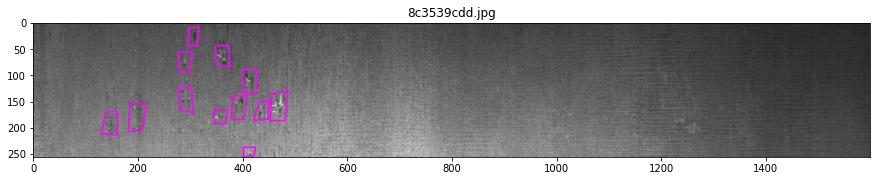

In [72]:
make_show_mask(991, sample_df)

## 2. Training
### Training was performed with pytorch lightning framework. Pretrained model for binary segmentation was taken from https://github.com/qubvel/segmentation_models.pytorch/blob/master/README.md 
### Model is based on Unet with resnet-18 encoder with imagenet pretrained weights.
### Binary Cross-Entropy was chosen as criterion. Were performed attempts to combine it with Dice loss as well.

#### Due to circumstances (such as time limits on usage of free GPU on colab) model had difficulties with debugging and improving.

Training was done in second notebook.